In [9]:
import os
import pandas as pd
import numpy as np
import random

from sklearn.metrics import f1_score, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from yellowbrick.regressor import PredictionError, ResidualsPlot

%matplotlib inline
pd.set_option('display.max_columns', 55)

In [2]:
#read in csv
df = pd.read_csv("eda.csv")

### See notebook 2 features selection for explanation about why we choosed those features and split train test method

In [3]:
features = df[[
    'x', 
    'y',
    'dayofweek', 
    'sin_day', 
    'cos_day',
    'sin_year', 
    'cos_year', 
    'TEMP', 
    'cos_wind', 
    'sin_wind', 
    'Wind-Rate', 
    'DEW', 
    'SKY', 
    'VIS', 
    'ATM'
]].astype(np.float64)

features.loc[:,'dayofweek'] = features['dayofweek'].astype('category')

labels = df[[
    'pm25',
    'AQI_VALUE', #pm25 transformed using EPA methodology See DATA Wrangling notebook
    'AQI_class'  #pm25 transformed into EPA categorical class  See DATA Wrangling notebook
]]
labels.loc[:,"polluted"] = (labels.loc[:,"AQI_class"] != "Good")

y=df['pm25'].values
X=features

gs = df[['station_id']]

def tts_gs(X, y, gs, test_size):
    stations = gs["station_id"].unique()
    nb_stations = len(stations) * test_size
    my_randoms = random.sample(list(stations), int(nb_stations))
    filters = gs["station_id"].isin(my_randoms)
    print('Substations selected for testing are : ')
    print(my_randoms)
    return X[~filters], X[filters], y[~filters], y[filters]


numericColumns = ['x','y',
    'dayofweek', 'sin_day', 'cos_day', 'sin_year', 'cos_year', 
    'TEMP', 'cos_wind', 'sin_wind', 'Wind-Rate', 'DEW', 'SKY', 'VIS',  'ATM'
    ]
categoricalColumns = ['dayofweek']

numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [4]:
visualizer = GradientBoostingRegressor()

visualizer.fit(X, y)  # Fit the training data to the visualizer
visualizer.predict(X)

array([ 9.35476079, 15.87567898, 15.76994701, ...,  6.29723848,
        6.55711791,  8.85092139])

Substations selected for testing are : 
['14th & S ST NW', 'MA_EPA_1']


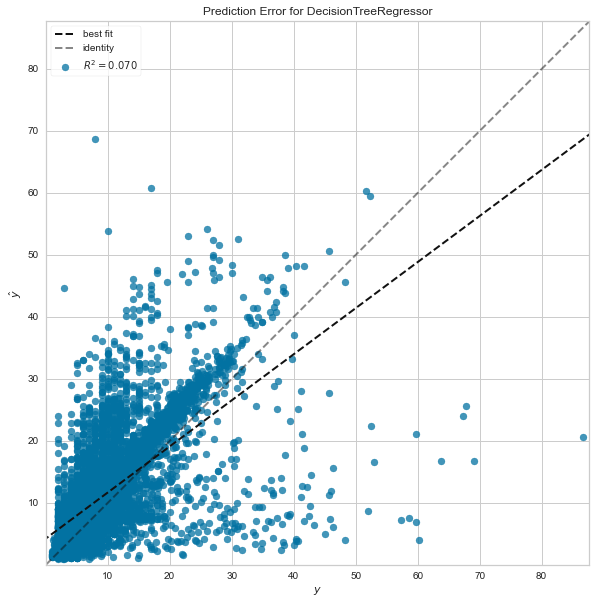

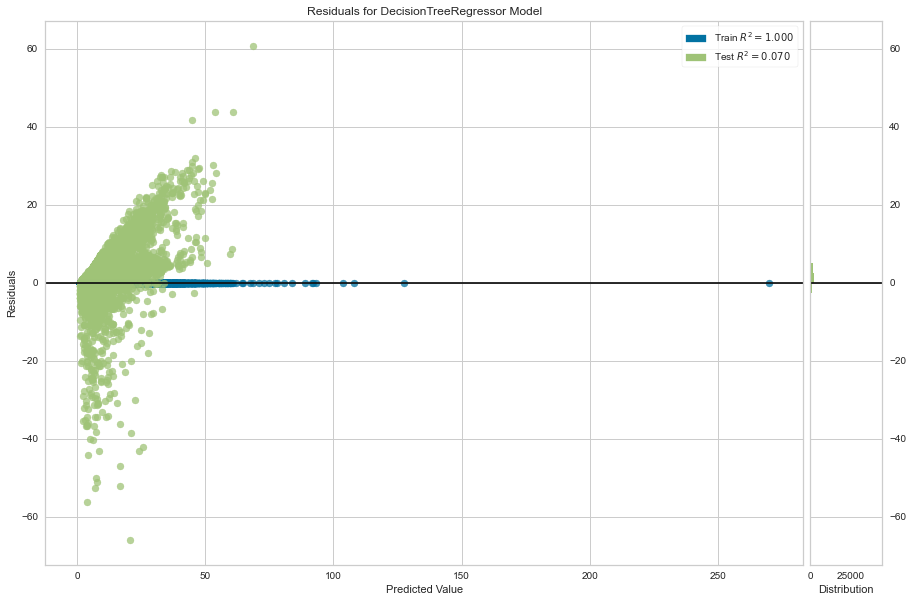

In [10]:

# Create the train and test data
X_train, X_test, y_train, y_test = tts_gs(X, y, gs, test_size=0.2)

# Instantiate the linear model and visualizer
model = DecisionTreeRegressor()
visualizer = PredictionError(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

visualizer = ResidualsPlot(model, size=(1080, 720))
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

## Testing different regression model using folding groups by stations strategy

* First we create 5 groups of stations to test the model using the rest of the data to train
* we train 5 time the data and test it against each group (training and testing data are always excluding sames stations id)
* We analyse mean and variance for each RSquare results 
* Each model will be train/test using sames 5 groups


In [6]:
def tts_grps(X, y, groups):
    filters = gs["station_id"].isin(groups)
    print('Test substations selected: ')
    print(groups)
    return X[~filters], X[filters], y[~filters], y[filters]
    

stations = list(gs["station_id"].unique())
stations_groups = [[], [], [], [], []]

totStations = len(stations)
for i in range(totStations):
    random_item_from_list = random.choice(stations)
    stations.remove(random_item_from_list)
    stations_groups[i % 5].append(random_item_from_list)

dfScores = pd.DataFrame(
    columns = ['model', 'group1', 'group2', 'group3', 'group4', 'group5', 'rsquare Var', 'rsquare mean']
)

models = [
    LinearRegression
    ,KNeighborsRegressor
    ,BayesianRidge
    ,GradientBoostingRegressor
    ,MLPRegressor
    ,DecisionTreeRegressor
]

for estimator_ in models:
    scores = []
    model_name = str(estimator_).split("(")[0]
    print("Model {} ".format(model_name))
    for groups in stations_groups:
        X_train, X_test, y_train, y_test = tts_grps(X, y, groups)
        
        #Note if you dont reinstanciate DecisionTreeRegressor will give you weirds fits after first pass
        estimator = estimator_()
        
        model = Pipeline([
         ("ColumnTransformer", ColumnTransformer(
            transformers=[
            ('num', numeric_transformer, numericColumns),
            ('cat', categorical_transformer, categoricalColumns)])),
         ('estimator', estimator)
        ])
        
        #Waiting for @bbengfort feature here :D https://github.com/DistrictDataLabs/yellowbrick/issues/498    
        #visualizer = PredictionError(model, size=(1080, 720))
        #visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
        #rsquare = visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        #visualizer.show()
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        y_predicted = model.predict(X_test)
        rsquare = r2_score(y_test, y_predicted)
        print(" > Score {} and rsquare {}\n".format(score, rsquare))
        scores.append(rsquare)
    print(" >> Mean rsquare {}\n\n".format(sum(scores) / len(stations_groups)))
    mean = sum(scores) / len(stations_groups)
    scores.append(sum((i - mean) ** 2 for i in scores) / len(scores))
    scores.append(mean)
    scores.insert(0, model_name)
    print(scores)
    dfScores.loc[len(dfScores)] = scores


Model <class 'sklearn.linear_model._base.LinearRegression'> 
Test substations selected: 
['MA_EPA_2', 'McMillan 1', 'DC_EPA_1']
 > Score -0.702871249198637 and rsquare -0.7028712491986371

Test substations selected: 
['14th & S ST NW', 'DC_EPA_4', 'V Street']
 > Score 0.09414138615785017 and rsquare 0.09414138615785017

Test substations selected: 
['VA_EPA', '13th & E ST SE', 'DC_EPA_3']
 > Score -0.06615307264707226 and rsquare -0.06615307264707226

Test substations selected: 
['Courthouse', 'DC_EPA_2', 'MA_EPA_1']
 > Score -0.16612667274400228 and rsquare -0.16612667274400228

Test substations selected: 
['Cheverly', 'Arlington']
 > Score 0.04347529679425921 and rsquare 0.04347529679425921

 >> Mean rsquare -0.15950686232752045


["<class 'sklearn.linear_model._base.LinearRegression'>", -0.7028712491986371, 0.09414138615785017, -0.06615307264707226, -0.16612667274400228, 0.04347529679425921, 0.08190855994778237, -0.15950686232752045]
Model <class 'sklearn.neighbors._regression.KNeigh

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 > Score -18.503900386308175 and rsquare -18.503900386308175

Test substations selected: 
['14th & S ST NW', 'DC_EPA_4', 'V Street']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 > Score 0.31213550175641747 and rsquare 0.31213550175641747

Test substations selected: 
['VA_EPA', '13th & E ST SE', 'DC_EPA_3']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 > Score 0.14198927575858 and rsquare 0.14198927575858

Test substations selected: 
['Courthouse', 'DC_EPA_2', 'MA_EPA_1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 > Score -1.1671995172188376 and rsquare -1.1671995172188376

Test substations selected: 
['Cheverly', 'Arlington']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 > Score -0.06800114741560015 and rsquare -0.06800114741560015

 >> Mean rsquare -3.856995254685523


["<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>", -18.503900386308175, 0.31213550175641747, 0.14198927575858, -1.1671995172188376, -0.06800114741560015, 53.89936718560311, -3.856995254685523]
Model <class 'sklearn.tree._classes.DecisionTreeRegressor'> 
Test substations selected: 
['MA_EPA_2', 'McMillan 1', 'DC_EPA_1']
 > Score -0.9968180406931915 and rsquare -0.9968180406931915

Test substations selected: 
['14th & S ST NW', 'DC_EPA_4', 'V Street']
 > Score -0.1695959675839216 and rsquare -0.1695959675839216

Test substations selected: 
['VA_EPA', '13th & E ST SE', 'DC_EPA_3']
 > Score -0.6794294635160758 and rsquare -0.6794294635160758

Test substations selected: 
['Courthouse', 'DC_EPA_2', 'MA_EPA_1']
 > Score -0.2238727727665495 and rsquare -0.2238727727665495

Test substations selected: 
['Cheverly', 'Arlington']
 > Score -0.09995881880184543 and rsquare -0.0

In [7]:
dfScores.head(12)

,model,group1,group2,group3,group4,group5,rsquare Var,rsquare mean
0,<class 'sklearn.linear_model._base.LinearRegre...,-0.702871,0.094141,-0.066153,-0.166127,0.043475,0.081909,-0.159507
1,<class 'sklearn.neighbors._regression.KNeighbo...,-0.227923,0.547875,0.301412,0.238347,0.152194,0.063629,0.202381
2,<class 'sklearn.linear_model._bayes.BayesianRi...,-0.699237,0.094671,-0.065771,-0.165153,0.043324,0.081174,-0.158433
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,-0.026633,0.315593,0.218278,0.370938,0.084876,0.021452,0.192611
4,<class 'sklearn.neural_network._multilayer_per...,-18.503900,0.312136,0.141989,-1.167200,-0.068001,53.899367,-3.856995
5,<class 'sklearn.tree._classes.DecisionTreeRegr...,-0.996818,-0.169596,-0.679429,-0.223873,-0.099959,0.120529,-0.433935


## Conclusion

* Best regression model among seems to be KNeighborsRegressor 
* Mean of RSquare 0.2 with a variance of 0.06

We concluded that regressions were maybe too complex and because our data product can support a more simple binary classification, we decided to invest more time into classifiers
